# Example of Matrix Factorization
Show how a matrix can be broken down into two smaller matrices. In this example, an image of the surface of the sun is used as a 2D matrix. This matrix could also be a users/ratings martix like in a reccomender system

The original matix is call V and the two new matrices are called W and H. W and H are selected such that V=W.dot(H)

To satisfy the rules of the matrix multiplication, if the dimension of V is (m)x(n), the dimensions of W must be (m)x(p) and the dimensions of H must be (p)x(n). Note that in matrix multiplication, the inner dimension (p) must be the same in the two matrices and cancels out. Therefore, p can be any number, regardless of the size of V.

If p is a larger number, W.dot(H) will faithfully reproduce V. As p decreases, W.dot(H) will be an approximation of V, with decreased fidelity.

## Motivation
Breaking a matrix down into two smaller matrices povides the following benefits:
1. Reduces the amount of data necessary to store the matrix. If the first matrix is (m)x(n) and the smaller matrices are (m)x(p) and (p)x(n), the amount of data in the two matrices will be smaller than in the first matrix if p < (nm)/(n+m).
2. Provides some error-correction or ability to fill in missing data. If there are some missing data points in V, (for example, most users have seen and rated a movie, but a few have not), the approximation W.dot(H) will fill in approximate values for the missing data based on the row and column around that data point



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
sun_image = Image.open('sun.jpeg')
sun_image.mode

'RGB'

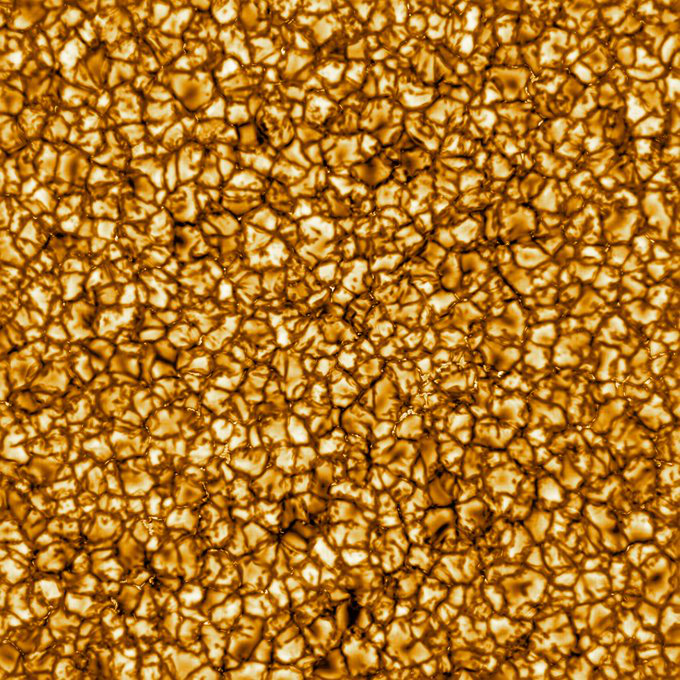

In [3]:
sun_image

Observe that this image can be represented as an 3D array, with shape (rows, columns, colors). Like most images, this is an RGB image, meaning the three colors are Red, Green and Blue. Each pixel is represented by an integer in the range of (0, 255).

Let's select just the Red channel, which is a 2D matrix.

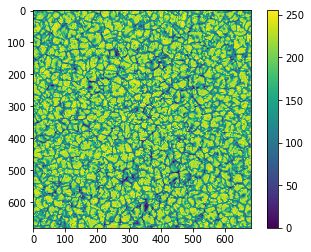

In [4]:
Red = np.array(sun_image)[:,:,0]
plt.imshow(Red)
plt.colorbar()


We now delete about 20% of the values out of this array

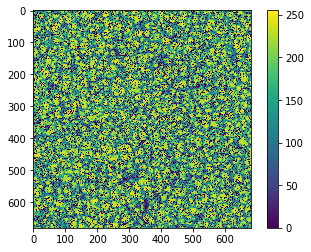

In [5]:
decimated_red = Red*(np.random.random(size=Red.shape)>.2)
plt.imshow(decimated_red)
plt.colorbar()

We now create the matrices W and H. There is no way to derive W and H directly from V, so we can use an approach based on (1) guessing starting values and (2) making incremental improvements.

First, we construct W of random numbers.

In [6]:
# Select a value for p that is 1/4 the size of the n in the original
p = Red.shape[1]/4
W = np.random.random(size = (Red.shape[0], int(p)))

Having guessed random numbers for W, we now fit H such that V=W.dot(H) using least squares. This first approximation of H is then used to fit W, so that after the first iteration W is no longer random numbers. 
Having obtained an improved W, we then refit, H, and then refit W, in an iterative manner.
Experiments show that about 50 iterations are sufficient.

In [7]:
for i in range(50):
    H = np.linalg.lstsq(W,decimated_red, rcond = None)[0]
    W = np.linalg.lstsq(H.T, decimated_red.T, rcond = None)[0].T

Having obtained stable values for W and H, the approximation of V is W.dot(H)

Let's plot the approximation side-by-side with the originals to see how they compare.


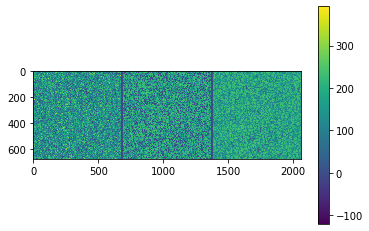

In [8]:
V = W.dot(H)
vertical_line = 0*V[:,:10]
comparison = np.hstack([V, vertical_line, decimated_red, vertical_line, Red])
plt.imshow(comparison)
plt.colorbar()

Note that the reconstruction, V, looks similar to both the original (Red) and the one with some elements removed (decimated_red). The reconstructed image contains some values outside of the range (0, 255).

The selection of the value p allows us to tune how faithful the reproduction is to the matrix it was trained on. 

If we choose a large p (approaching p = n/2), V will resememble decimated_red (including missing data points). 

If we choose a smaller p, V will do a better job of filling in missing data points, but will be more approximate everywhere.

## Let's repeat this process with a large p:

In [9]:
W = np.random.random(size = (Red.shape))
for i in range(50):
    H = np.linalg.lstsq(W,decimated_red, rcond = None)[0]
    W = np.linalg.lstsq(H.T, decimated_red.T, rcond = None)[0].T

We see that V now looks exactly like decimated_red

Text(0.5, 1.0, 'Note the mising data points are \n all faithfully represented')

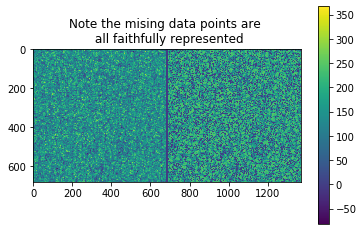

In [18]:
plt.imshow(np.hstack([W.dot(H), vertical_line, decimated_red]))
plt.colorbar()
plt.title('Note the mising data points are \n all faithfully represented')

### If we examine the residuals, we see that the reproduction is almost exact: (out to about 10 decimal places)

(array([     0.,      0.,      0.,      0.,      0., 462400.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

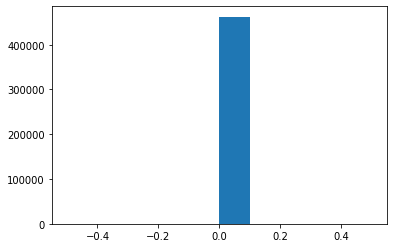

In [11]:
plt.hist((np.round(W.dot(H),8) - decimated_red).flatten())

### On the other hand, if we choose a smaller p, the reconstruction becomes less like decimated_red and more like the original data Red.

#### This is interesting because the reconstruction (W.dot(H)) was not built based on Red. 

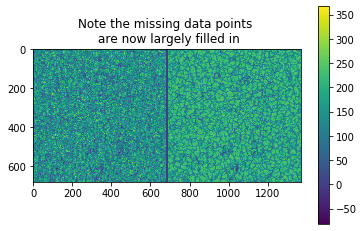

In [17]:
W = np.random.random(size = (Red.shape[0], int(Red.shape[1]/10)))
for i in range(50):
    H = np.linalg.lstsq(W,decimated_red, rcond = None)[0]
    W = np.linalg.lstsq(H.T, decimated_red.T, rcond = None)[0].T
plt.imshow(np.hstack([W.dot(H), vertical_line, Red]))
plt.title('Note the missing data points \n are now largely filled in')
plt.colorbar()

### Note that the residuals are now larger, but distrubuted evenly, much  like white noise. This is true whether we compare to the original data (Red), or the decimated data.

(array([1.07000e+02, 4.42200e+03, 4.76540e+04, 1.48818e+05, 1.37655e+05,
        5.37950e+04, 4.19220e+04, 2.37670e+04, 4.09100e+03, 1.69000e+02]),
 array([-215.16493433, -166.61135348, -118.05777262,  -69.50419176,
         -20.95061091,   27.60296995,   76.1565508 ,  124.71013166,
         173.26371252,  221.81729337,  270.37087423]),
 <a list of 10 Patch objects>)

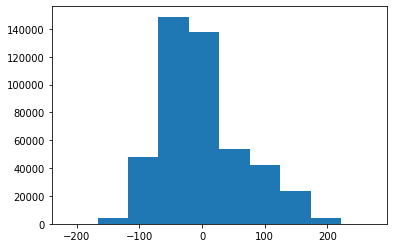

In [13]:
plt.hist((W.dot(H) - decimated_red).flatten())

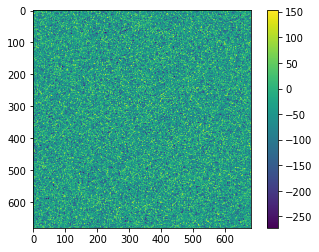

In [14]:
plt.imshow(W.dot(H)-Red)
plt.colorbar()

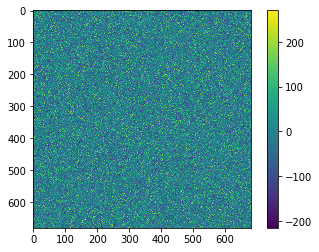

In [15]:
plt.imshow(W.dot(H)-decimated_red)
plt.colorbar()